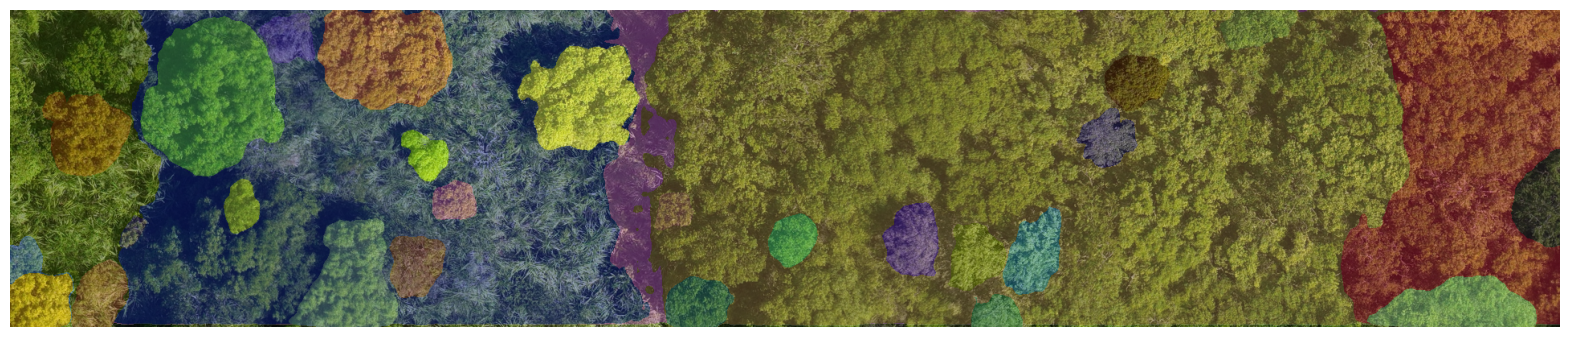

In [5]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

image = cv2.imread('G:\\Yehmh\DNDF\\86_1_clipped_image_2.tiff')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

# device = "cuda"
device = 'cpu'

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

masks = mask_generator.generate(image)

plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

In [32]:
print(type(masks))
print(type(masks[0]))
print(type(masks[0].values()))
print(len(masks[0]))
# print(masks[0])
print(masks[0].keys())
# print(masks[0].values())
# print(masks[0].items())
print(type(masks[0]['segmentation']))
print(type(masks[0]['area']))
print(masks[0]['area'])

<class 'list'>
<class 'dict'>
<class 'dict_values'>
7
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])
<class 'numpy.ndarray'>
<class 'int'>
755220


In [35]:
import numpy as np
import cv2
import geopandas as gpd
from shapely.geometry import Polygon
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
import rasterio

# Step 1: Define TM2 Transformation
def pixel_to_tm2(pixel_coords, tiff_file):
    # Open the TIFF file
    with rasterio.open(tiff_file) as src:
        # Transform pixel coordinates to map coordinates (TM2)
        tm2_coords = src.xy(pixel_coords[:, 1], pixel_coords[:, 0])
        print(tm2_coords)
        print(len(tm2_coords[0]))
        tm2_coords = np.array([tm2_coords[0], tm2_coords[1]])
        print(type(tm2_coords))
        print((tm2_coords).shape)
        tm2_coords = tm2_coords.T
        print((tm2_coords).shape)
    return tm2_coords

# Step 2: Modify masks_to_polygons function to include TM2 transformation
def masks_to_polygons(masks, tiff_file):
    polygons = []
    for mask in masks:
        mask_np = mask['segmentation'].astype(np.uint8)
        contours, _ = cv2.findContours(mask_np, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for contour in contours:
            # print(contour.shape)
            # print(contour)
            contour = contour.squeeze().reshape(-1, 2)
            # print(type(contour))
            print(contour.shape)
            # print(contour)
            if len(contour) >= 3:  # at least 3 points to form a polygon
                # Convert contour coordinates to TM2
                tm2_coords = pixel_to_tm2(contour, tiff_file)
                # Create Polygon object with TM2 coordinates
                polygons.append(Polygon(tm2_coords))
    return polygons


tiff_file = 'i:\\2024_NDHU research assistant\\DNDF\\86_1_clipped_image_2.tiff'

# Step 4: Convert masks to polygons
polygons = masks_to_polygons(masks, tiff_file)

# Step 5: Create a GeoDataFrame
crs = {'init': 'epsg:3826'}
gdf = gpd.GeoDataFrame({'geometry': polygons}, crs=crs)
print(type(gdf))
print(gdf)

# Step 6: Save to shapefile
output_shapefile = 'G:\\Yehmh\DNDF\\86_1_mask_all.shp'
gdf.to_file(output_shapefile)


(163, 2)
([292326.53391, 292326.53391, 292326.94687, 292326.99848999997, 292327.61792999995, 292327.66955, 292327.97926999995, 292328.03089, 292329.26976999996, 292329.32139, 292329.52787, 292329.57949, 292329.99244999996, 292330.04407, 292330.35378999996, 292330.40540999995, 292330.81837, 292330.86999, 292331.02485, 292331.07646999997, 292332.26373, 292332.31535, 292333.34774999996, 292333.39937, 292333.60585, 292333.65747, 292334.43176999997, 292334.48338999995, 292335.77388999995, 292335.82551, 292336.80629, 292336.85790999996, 292336.90953, 292336.96115, 292338.30327, 292338.35488999996, 292342.69097, 292342.74259, 292344.70415, 292344.75577, 292345.37520999997, 292345.42682999995, 292345.47845, 292351.05341, 292351.10503, 292351.31150999997, 292351.36312999995, 292351.82771, 292351.87932999997, 292353.78926999995, 292353.84089, 292353.99575, 292354.04737, 292355.54435, 292355.59596999997, 292355.95730999997, 292356.00892999995, 292356.98971, 292357.04133, 292357.60915, 292357.6607

c:\Users\CIRES\anaconda3\envs\test\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\CIRES\anaconda3\envs\test\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<class 'geopandas.geodataframe.GeoDataFrame'>
                                             geometry
0   POLYGON ((292326.534 2613041.018, 292326.534 2...
1   POLYGON ((292367.469 2613023.261, 292367.417 2...
2   POLYGON ((292366.849 2613024.448, 292366.849 2...
3   POLYGON ((292366.798 2613026.978, 292366.746 2...
4   POLYGON ((292366.746 2613028.423, 292366.694 2...
5   POLYGON ((292368.759 2613032.862, 292368.656 2...
6   POLYGON ((292367.210 2613034.772, 292367.210 2...
7   POLYGON ((292370.204 2613041.018, 292370.204 2...
8   POLYGON ((292326.534 2613041.018, 292326.534 2...
9   POLYGON ((292326.534 2613041.018, 292326.534 2...
10  POLYGON ((292347.234 2613041.018, 292347.234 2...
11  POLYGON ((292365.507 2613038.695, 292365.455 2...
12  POLYGON ((292327.721 2613024.087, 292327.670 2...
13  POLYGON ((292340.213 2613040.554, 292340.162 2...
14  POLYGON ((292385.277 2613028.629, 292385.226 2...
15  POLYGON ((292397.202 2613034.669, 292397.150 2...
16  POLYGON ((292332.832 2613024.964